In [22]:
# !pip install demoji

In [23]:
import pandas as pd
import re

import regex
import demoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

### Paso 1: Definir funciones necesarias

In [24]:
# Patron regex para identificar el comienzo de cada línea del txt con la fecha y la hora
def IniciaConFechaYHora(s):
    # Ejemplo: '9/16/23, 5:59 PM - ...'
    patron = '^([1-9]|1[0-2])(\/)([1-9]|1[0-9]|2[0-9]|3[0-1])(\/)(2[0-9]), ([0-9]+):([0-9][0-9])\s?([AP][M]) -'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

# Patrón para encontrar a los miembros del grupo dentro del txt
def EncontrarMiembro(s):
    patrones = ['Yo 🤙:','Tú ❤️:']

    patron = '^' + '|'.join(patrones)
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de miembro
    if resultado:
        return True
    return False

# Separar las partes de cada línea del txt: Fecha, Hora, Miembro y Mensaje
def ObtenerPartes(linea):
    # Ejemplo: '9/16/23, 5:59 PM - Sandreke: Todos debemos aprender a analizar datos'
    splitLinea = linea.split(' - ')
    FechaHora = splitLinea[0]                     # '9/16/23, 5:59 PM'
    splitFechaHora = FechaHora.split(', ')
    Fecha = splitFechaHora[0]                    # '9/16/23'
    Hora = ' '.join(splitFechaHora[1:])          # '5:59 PM'
    Mensaje = ' '.join(splitLinea[1:])             # 'Sandreke: Todos debemos aprender a analizar datos'
    if EncontrarMiembro(Mensaje):
        splitMensaje = Mensaje.split(': ')
        Miembro = splitMensaje[0]               # 'Sandreke'
        Mensaje = ' '.join(splitMensaje[1:])    # 'Todos debemos aprender a analizar datos'
    else:
        Miembro = None       
    return Fecha, Hora, Miembro, Mensaje

### Paso 2: Obtener el dataframe usando el archivo txt y las funciones definidas

In [25]:
# Leer el archivo txt descargado del chat de WhatsApp
RutaChat = 'Data/WhatsApp Chat with Mi amor ❤️.txt'

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
DatosLista = []
with open(RutaChat, encoding="utf-8") as fp:
    fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    Fecha, Hora, Miembro = None, None, None
    while True:
        linea = fp.readline()
        if not linea:
            break
        linea = linea.strip()
        if IniciaConFechaYHora(linea): # Si cada línea del txt coincide con el patrón fecha y hora
            Fecha, Hora, Miembro, Mensaje = ObtenerPartes(linea) # Obtener datos de cada línea del txt
            DatosLista.append([Fecha, Hora, Miembro, Mensaje])

# Convertir la lista con los datos a dataframe
df = pd.DataFrame(DatosLista, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%m/%d/%y")

# Eliminar los posibles campos vacíos del dataframe
# y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
df = df.dropna()

# Resetear el índice
df.reset_index(drop=True, inplace=True)
df

,Fecha,Hora,Miembro,Mensaje
0,2023-03-07,8:32 AM,Tú ❤️,Pero
1,2023-03-07,8:32 AM,Tú ❤️,No quiero estar en el plan de apurarme
2,2023-03-07,8:33 AM,Tú ❤️,Por eso con calma y tiempo a las 11
3,2023-03-07,8:33 AM,Tú ❤️,O 10 no crees?
4,2023-03-07,8:33 AM,Tú ❤️,💕
...,...,...,...,...
39270,2023-09-28,12:53 PM,Tú ❤️,Si
39271,2023-09-28,12:54 PM,Tú ❤️,Yo también te amo mucho mi amor
39272,2023-09-28,12:54 PM,Tú ❤️,❤️
39273,2023-09-28,12:54 PM,Yo 🤙,"No quiero que estés triste, mi gran bombón"


#### Filtrar el chat por fecha de acuerdo a lo requerido

In [26]:
start_date = '2023-01-01'
end_date = '2024-02-01'

df = df[(df['Fecha'] >= start_date) & (df['Fecha'] <= end_date)]
df

,Fecha,Hora,Miembro,Mensaje
0,2023-03-07,8:32 AM,Tú ❤️,Pero
1,2023-03-07,8:32 AM,Tú ❤️,No quiero estar en el plan de apurarme
2,2023-03-07,8:33 AM,Tú ❤️,Por eso con calma y tiempo a las 11
3,2023-03-07,8:33 AM,Tú ❤️,O 10 no crees?
4,2023-03-07,8:33 AM,Tú ❤️,💕
...,...,...,...,...
39270,2023-09-28,12:53 PM,Tú ❤️,Si
39271,2023-09-28,12:54 PM,Tú ❤️,Yo también te amo mucho mi amor
39272,2023-09-28,12:54 PM,Tú ❤️,❤️
39273,2023-09-28,12:54 PM,Yo 🤙,"No quiero que estés triste, mi gran bombón"


In [27]:
# df[df['Miembro']=='Yo 🤙:']

### Paso 3: Estadísticas de mensajes, multimedia, emojis y links

#### Total de mensajes, multimedia, emojis y links enviados

In [28]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje)  # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if demoji.replace(caracter) != caracter:
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Media omitted>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'POLL:'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,39275
Multimedia,5286
Emojis,11321
Links,78
Encuestas,1


#### Emojis más usados

In [29]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji').head(10)

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df

Número emojis únicos usados:  10 



,Cantidad
Emoji,
❤️,2505
🥰,2434
💕,1336
💞,744
♥️,554
😼,311
🤧,301
😂,272
😔,182


In [30]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis', hole=.3, template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Pastel2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Paso 4: Estadísticas de los miembros del grupo

#### Miembros más activos

In [31]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos['% Mensaje'] = (df_MiembrosActivos['Mensaje'] / df_MiembrosActivos['Mensaje'].sum()) * 100
df_MiembrosActivos

,Miembro,Mensaje,% Mensaje
1,Tú ❤️,22965,58.472311
2,Yo 🤙,16310,41.527689


#### Estadísticas por miembro

In [32]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Media omitted>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,Letras,Palabras
39270,2023-09-28,12:53 PM,Tú ❤️,Si,[],0,2,1
39271,2023-09-28,12:54 PM,Tú ❤️,Yo también te amo mucho mi amor,[],0,31,7
39272,2023-09-28,12:54 PM,Tú ❤️,❤️,[❤️],0,2,1
39273,2023-09-28,12:54 PM,Yo 🤙,"No quiero que estés triste, mi gran bombón",[],0,42,8
39274,2023-09-28,12:54 PM,Yo 🤙,a qué hora andas free? <3,[],0,25,6


In [33]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
    lista = []
    # Filtrar mensajes de un miembro en específico
    miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

    # Agregar a la lista el número total de mensajes enviados
    lista.append(miembro_df.shape[0])
    
    # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
    palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
    lista.append(palabras_por_msj)

    # Agregar a la lista el número de mensajes multimedia enviados
    multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
    lista.append(multimedia)

    # Agregar a la lista el número total de emojis enviados
    emojis = sum(miembro_df['Emojis'].str.len())
    lista.append(emojis)

    # Agregar a la lista el número total de links enviados
    links = sum(miembro_df['URLs'])
    lista.append(links)

    # Asignar la lista como valor a la llave del diccionario
    dictionario[miembros[i]] = lista
    
print(dictionario)

{'Tú ❤️': [20369, 5.5757278216898225, 2596, 6969, 29], 'Yo 🤙': [13620, 5.785462555066079, 2690, 4352, 49]}


In [34]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df = miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Tú ❤️,20369,5.575728,2596,6969,29
Yo 🤙,13620,5.785463,2690,4352,49


### Paso 5: Estadísticas del comportamiento del grupo

In [35]:
df['rangoHora'] = pd.to_datetime(df['Hora'], format='%I:%M %p')

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    hour = pd.to_datetime(hour)  # Convertir a objeto de Python datetime si es necesario
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# # Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,rangoHora
0,2023-03-07,8:32 AM,Tú ❤️,Pero,[],0,08 - 09 h
1,2023-03-07,8:32 AM,Tú ❤️,No quiero estar en el plan de apurarme,[],0,08 - 09 h
2,2023-03-07,8:33 AM,Tú ❤️,Por eso con calma y tiempo a las 11,[],0,08 - 09 h
3,2023-03-07,8:33 AM,Tú ❤️,O 10 no crees?,[],0,08 - 09 h
4,2023-03-07,8:33 AM,Tú ❤️,💕,[💕],0,08 - 09 h
...,...,...,...,...,...,...,...
39270,2023-09-28,12:53 PM,Tú ❤️,Si,[],0,12 - 13 h
39271,2023-09-28,12:54 PM,Tú ❤️,Yo también te amo mucho mi amor,[],0,12 - 13 h
39272,2023-09-28,12:54 PM,Tú ❤️,❤️,[❤️],0,12 - 13 h
39273,2023-09-28,12:54 PM,Yo 🤙,"No quiero que estés triste, mi gran bombón",[],0,12 - 13 h


In [36]:
df['DiaSemana'] = df['Fecha'].dt.strftime('%A')
mapeo_dias_espanol = {'Monday': '1 Lunes','Tuesday': '2 Martes','Wednesday': '3 Miércoles','Thursday': '4 Jueves',
                      'Friday': '5 Viernes','Saturday': '6 Sábado','Sunday': '7 Domingo'}
df['DiaSemana'] = df['DiaSemana'].map(mapeo_dias_espanol)
df

,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,rangoHora,DiaSemana
0,2023-03-07,8:32 AM,Tú ❤️,Pero,[],0,08 - 09 h,2 Martes
1,2023-03-07,8:32 AM,Tú ❤️,No quiero estar en el plan de apurarme,[],0,08 - 09 h,2 Martes
2,2023-03-07,8:33 AM,Tú ❤️,Por eso con calma y tiempo a las 11,[],0,08 - 09 h,2 Martes
3,2023-03-07,8:33 AM,Tú ❤️,O 10 no crees?,[],0,08 - 09 h,2 Martes
4,2023-03-07,8:33 AM,Tú ❤️,💕,[💕],0,08 - 09 h,2 Martes
...,...,...,...,...,...,...,...,...
39270,2023-09-28,12:53 PM,Tú ❤️,Si,[],0,12 - 13 h,4 Jueves
39271,2023-09-28,12:54 PM,Tú ❤️,Yo también te amo mucho mi amor,[],0,12 - 13 h,4 Jueves
39272,2023-09-28,12:54 PM,Tú ❤️,❤️,[❤️],0,12 - 13 h,4 Jueves
39273,2023-09-28,12:54 PM,Yo 🤙,"No quiero que estés triste, mi gran bombón",[],0,12 - 13 h,4 Jueves


#### Número de mensajes por rango de hora

In [37]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
mensajes_hora = df.groupby('rangoHora').count().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(mensajes_hora, x='rangoHora', y='# Mensajes por hora', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
# fig.update_layout(
#     title={'text': 'Mensajes con ella ❤️ por hora',
#              'y':0.96,
#              'x':0.5,
#              'xanchor': 'center'},
#     font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

In [38]:
df
# df.groupby(['rangoHora','Miembro']).agg({'# Mensajes por hora': 'sum'}).reset_index()
df_filtrado = df[df['Miembro'] == 'Sandreke']
df_filtrado.groupby(['rangoHora']).size().reset_index(name='total_mensajes')

,rangoHora,total_mensajes


#### Número de mensajes por día

In [39]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('DiaSemana').count().reset_index()


# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='DiaSemana', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
# fig.update_layout(
#     title={'text': 'Mensajes con ella ❤️ por día', 'y':0.96, 'x':0.5, 'xanchor': 'center'},
#     font=dict(size=17))
fig.update_traces(mode='markers+lines', marker=dict(size=10))
fig.update_xaxes(title_text='Día', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

In [40]:
df.groupby('DiaSemana').count().reset_index()
# df.groupby(['DiaSemana']).size().reset_index(name='total_mensajes')


,DiaSemana,Fecha,Hora,Miembro,Mensaje,Emojis,URLs,rangoHora,# Mensajes por hora,# Mensajes por día
0,1 Lunes,5831,5831,5831,5831,5831,5831,5831,5831,5831
1,2 Martes,5420,5420,5420,5420,5420,5420,5420,5420,5420
2,3 Miércoles,6073,6073,6073,6073,6073,6073,6073,6073,6073
3,4 Jueves,5480,5480,5480,5480,5480,5480,5480,5480,5480
4,5 Viernes,5444,5444,5444,5444,5444,5444,5444,5444,5444
5,6 Sábado,5993,5993,5993,5993,5993,5993,5993,5993,5993
6,7 Domingo,5034,5034,5034,5034,5034,5034,5034,5034,5034


#### Número de mensajes a través del tiempo

In [41]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum().reset_index()

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día', color_discrete_sequence=['salmon'], template='plotly_dark')

# Ajustar el gráfico
# fig.update_layout(
#     title={'text': 'Mensajes con ella ❤️',
#              'y':0.96,
#              'x':0.5,
#              'xanchor': 'center'},
#     font=dict(size=17))

fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

#### Word Cloud de palabras más usadas

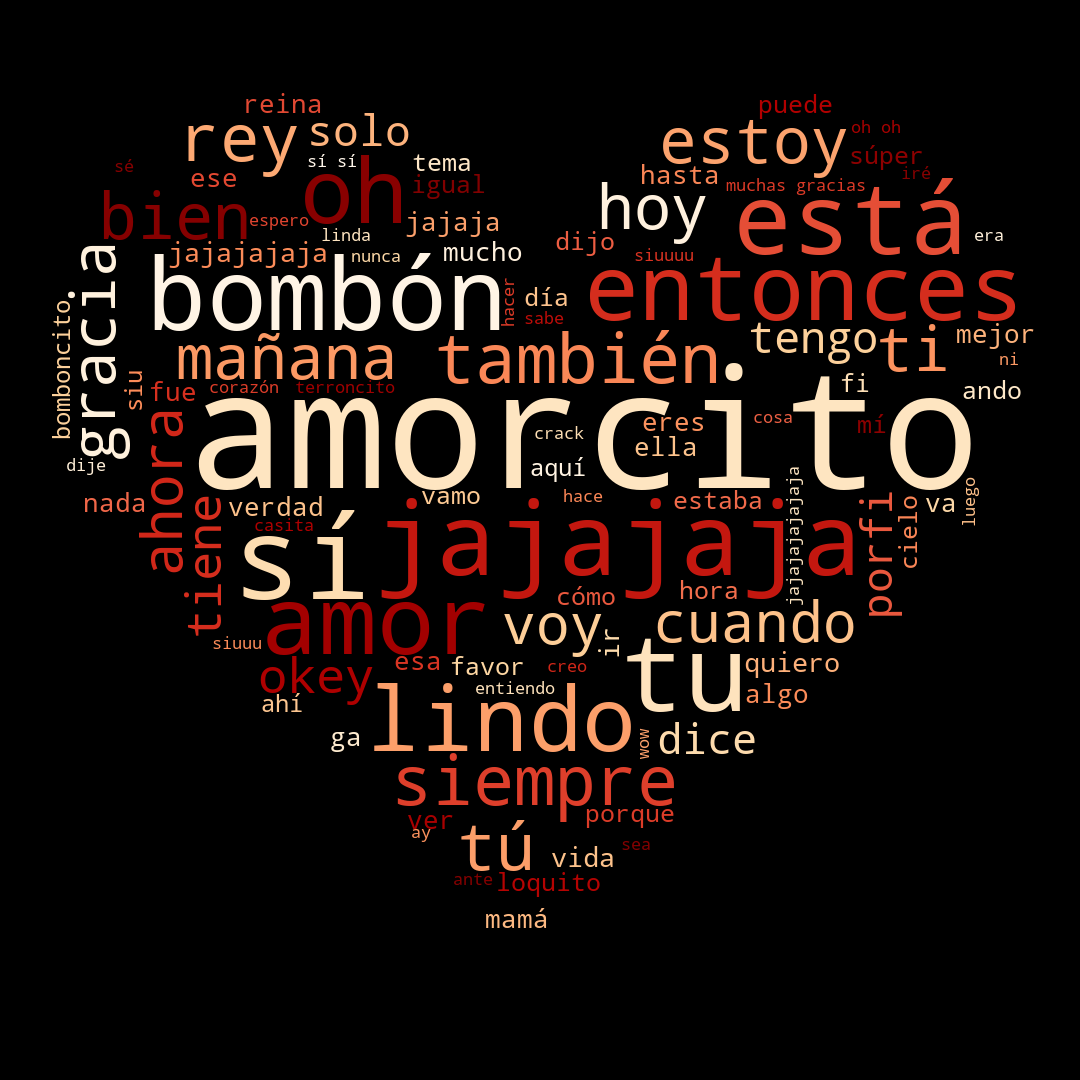

In [42]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Media','omitted',
                              'y', 'mi', 'o', 'q', 'yo', 'al'])

mask = np.array(Image.open('Resources/heart.jpg'))

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', stopwords = stopwords,
                      max_words=100, min_font_size = 5,
                      mask = mask, colormap='OrRd',).generate(total_palabras)

# Plotear la nube de palabras más usadas
wordcloud.to_image()